# Policy gradient actually 

## Disable warnings and import imports

In [92]:
import warnings
warnings.filterwarnings('ignore')

In [93]:
import numpy as np
import gym
import multiprocessing
import tensorboard
import tensorflow as tf
from datetime import datetime
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Define config vars

In [94]:
USING_CPU = False
ENV_NAME = 'CartPole-v0'
NPROC = multiprocessing.cpu_count() - 1 if USING_CPU else 8
BATCH_SIZE = 2 ** 14

## Func to create env

In [95]:
def make_env(name, seed):
    def __f():
        env = gym.make(name)
        env.seed(seed)
        env.reset()
        for i in range(int(env.spec.max_episode_steps * seed // NPROC)):
            env.step(env.action_space.sample())
        return env
    return __f

## This class makes all the work

In [96]:
class PGAgent(object):
    
    def __init__(
        self, envs, batch_size, env_name
    ):
        '''Policy gradient agent'''
        self._n_envs = envs.num_envs
        self.env_name = env_name
        self._bs = batch_size
        self._training_history = {
            'rewards': []
        }
        
        # handle spaces sizes and data types
        if isinstance(envs.action_space, gym.spaces.discrete.Discrete):
            self._actions_size = envs.action_space.n 
            self._actions_dtype = 'int32'
        else:
            self._actions_size = envs.action_space.shape[0]
            self._actions_dtype = 'float32'
            
        if isinstance(envs.observation_space, gym.spaces.discrete.Discrete):
            self._observations_size = envs.observation_space.n 
            self._observations_dtype = 'int32'
        else:
            self._observations_size = envs.observation_space.shape[0]
            self._observations_dtype = 'float32'
        
        self._rewards_dtype = 'float32'

        self._policy = self.__create_policy()
        self._batch_gen = self.__get_batch_gen()
        self._optimizer = tf.keras.optimizers.Adam(0.001)
    
    def plot(self, stat='rewards'):
        '''plots training statistics'''
        plt.xlabel('epochs')
        plt.ylabel(stat)
        plt.plot(self._training_history['rewards'])
        
    def visualize(self, n_epochs=1000):
        env = gym.make(self.env_name)
        obs = env.reset()
        for _ in range(n_epochs):
            env.render()
            action = self.get_actions(obs)
            obs, rew, done,  _ = env.step(action)
            if done:
                obs = env.reset()
        env.close()

    
    def __get_batch_gen(self):
        '''returns python generator of batches'''
        while True:
            
            batch = np.empty((0, 3))
            trajectories = [np.empty((0, 3)) for _ in range(self._n_envs)]
            new_observations = envs.buf_obs[None]  # last observations

            while len(batch) < self._bs:
                observations = new_observations
                actions = self.get_actions(observations, explore=True)
                new_observations, rewards, dones, _ = envs.step(actions)
                for i in range(self._n_envs):
                    trajectories[i]  = np.concatenate((
                        trajectories[i], 
                        np.expand_dims([observations[i], actions[i], rewards[i]], axis=0)
                    ))
                    if dones[i]:
                        trajectories[i][:, 2] = self.__rew_to_go(trajectories[i][:, 2])
                        batch = np.concatenate((batch, trajectories[i][:]))
                        trajectories[i] = np.empty((0, 3))
            
            np.random.shuffle(batch)
            self._training_history['rewards'].append(batch[:, 2].sum() / batch.shape[1])
            yield batch
                
    def __rew_to_go(self, rews, epsilon=0.95):
        '''returns cumulative discounted sum'''
        return np.cumsum(
            np.multiply(
                rews,
                np.array([epsilon**i for i in range(len(rews))])
            )[::-1]
        )[::-1]    
        
    def __create_policy(self):
        '''return neural network which which approximates observation -> actions' probabilities' logit''' 
        inp = tf.keras.layers.Input(shape=(self._observations_size,), name='input')
        x = tf.keras.layers.Dense(
            units=2**5, name='hidden', activation='relu',
            kernel_initializer='random_uniform',
            bias_initializer='ones',
        )(inp)
        x = tf.keras.layers.Dense(
            units=self._actions_size, name='logits', activation='linear',
            kernel_initializer='random_uniform',
            bias_initializer='ones',
        )(x)
        model = tf.keras.models.Model([inp], [x])
        return model
    
    def get_actions(self, observations, explore=False):
        '''returns actions for observations
        if explore=True, it will pick actions stochastically'''
        observations = np.array(observations)
        single_obs = observations.ndim == 1
        observations = np.expand_dims(observations, axis=0) if single_obs else observations
        preds = self._policy.predict_on_batch(observations)
        if explore:
            actions = tf.squeeze(tf.random.categorical(preds, 1))
        else:
            actions = np.argmax(preds, axis=1)
        return actions[0] if single_obs else  np.array(actions, dtype=self._actions_dtype) 

    def train(self, n_epochs, lr=None):
        '''train policy'''
        if lr:
            self._optimizer._set_hyper('lr', lr)
        
        # tensorboard stuff
        stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
        logdir = 'logs/policy_gradient/%s' % stamp
        writer = tf.summary.create_file_writer(logdir)


        for i in range(n_epochs):
            clear_output()
            print("EPOCH %d" % i)
            batch = next(self._batch_gen)
            obses, acts, rews = [batch[:, i] for i in range(batch.shape[1])]
            # create valid observations tensor for training
            obses = np.stack(obses)
            obses = tf.Variable(obses, dtype=self._observations_dtype)
            # create one hot actions
            acts = tf.Variable(acts, dtype=self._actions_dtype)
            acts = tf.one_hot(acts, self._actions_size)
            # create rewards tensor
            rews = tf.Variable(rews, dtype=self._rewards_dtype)
            #tensorboard stuff
            tf.summary.trace_on(graph=True, profiler=True)
            # actually train policy
            self.__train_on_batch(obses, acts, rews)
            
            # tensorboard stuff
            with writer.as_default():
                tf.summary.trace_export(
                    name="train_on_batch_trace",
                    step=0,
                    profiler_outdir=logdir
                )
        tf.keras.backend.clear_session()
    
    def __train_on_batch(self, obses, acts, rews):
        '''maximizes mean reward by updating _policy weights'''
        with tf.GradientTape() as t: 
            t.watch(self._policy.trainable_weights)
            logits = self._policy(obses)
            log_actions_probability = tf.nn.log_softmax(logits)
            log_prob = tf.reduce_sum(tf.math.multiply(acts, log_actions_probability), axis=1)
            objective = -tf.reduce_mean(tf.math.multiply(rews, log_prob))
        gradients = t.gradient(objective, self._policy.trainable_weights)
        self._optimizer.apply_gradients(zip(gradients, self._policy.trainable_weights))
        
    def save(self, filename):
        self._policy.save(filename)
        
    def load(self, filename):
        self._policy = tf.keras.models.load_model(filename)

In [97]:
if __name__ == '__main__':
    if USING_CPU:
        envs = SubprocVecEnv([make_env(ENV_NAME, i) for i in range(NPROC)])
    else:
        envs = DummyVecEnv([make_env(ENV_NAME, i) for i in range(NPROC)])
    agent = PGAgent(
        envs, BATCH_SIZE, ENV_NAME
    )
    agent.train(5, 0.01)
    agent.save('models/' + ENV_NAME + '_model.h5')

EPOCH 4
[[ 0.04610695  0.04408259 -0.01760525 -0.02880555]
 [-0.0383167  -0.57322377  0.04165439  0.9203374 ]
 [ 0.05032595 -0.3493877   0.01082487  0.5718041 ]
 [ 0.1113181   0.9853189  -0.09905861 -1.4445825 ]
 [-0.05900694 -0.42312977  0.12632534  0.7415799 ]
 [-0.04284314  0.01806749 -0.02503787  0.01888229]
 [ 0.00677866  0.03147035 -0.01531571 -0.04515259]
 [ 0.10832302  0.54764086 -0.18190189 -1.0595177 ]]


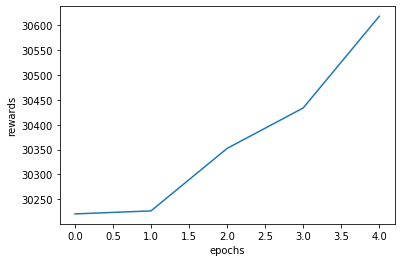

In [98]:
agent.plot()

In [99]:
agent.visualize(100)